In [ ]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold





In [3]:
raw_df = pd.read_csv("../forestCover.csv", na_values="?")
raw_df = raw_df.rename(columns={"Observation_ID":"Water_Level" , "Water_Level":"Observation_ID"})
# display(raw_df)

In [4]:
na_col = raw_df.columns[raw_df.isna().any()]
# print(na_col)
raw_df["Slope"].isna().sum()

np.int64(298)

In [5]:
print(f"Corr of Inclination and Cover: {raw_df['Inclination'].corr(raw_df['Cover_Type'])}")
print(f"Corr of aspect and facet: {raw_df['Facet'].corr(raw_df['Aspect'])}")
print(f"Cardinality of water level: {raw_df['Water_Level'].nunique()}")
print(f"Cardinality of obs id: {raw_df['Observation_ID'].nunique()}")
df = raw_df.drop(columns={'Facet','Water_Level','Observation_ID', 'Inclination' })

na_rows = df.index[df.isna().any(axis=1)]
na_proportions = (df["Cover_Type"][na_rows].value_counts() /  df["Cover_Type"].value_counts() * 100).round(3)
print(na_proportions)
df = df.dropna()

df["Soil_Type1"] = (df["Soil_Type1"] == 'positive').astype(int)
df["Soil_Type1"].value_counts()

Corr of Inclination and Cover: 0.0002417782055169697
Corr of aspect and facet: 0.9999980536139016
Cardinality of water level: 1
Cardinality of obs id: 581012
Cover_Type
1    0.045
2    0.055
3    0.053
4    0.036
5    0.021
6    0.069
7    0.054
Name: count, dtype: float64


Soil_Type1
1    577685
0      3029
Name: count, dtype: int64

In [10]:
continuous_features = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

# # Plot distributions
# fig, axes = plt.subplots(len(continuous_features), 1, figsize=(5, 15))

# for i, col in enumerate(continuous_features):
#     sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="steelblue")
#     axes[i].set_title(f"Distribution of {col}")
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Count")

# plt.tight_layout()
# plt.show()

In [7]:
df_eng = df.copy()
df_eng["Relative_hoz_dist_mean"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].mean(axis=1)

df_eng["total_hillshade"] = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].sum(axis=1)
df_eng["Relative_height_from_water"] = df["Elevation"] - df["Vertical_Distance_To_Hydrology"]
df_eng = df_eng.drop(columns={"Elevation",  "Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Fire_Points","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon", "Hillshade_3pm"  })

In [8]:
X = df.drop(columns={"Cover_Type"})
X_eng = df_eng.drop(columns={"Cover_Type"})
y = df["Cover_Type"]
y_eng = df_eng["Cover_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eX_train, eX_test, ey_train, ey_test = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)



In [12]:
outlier_features = [
    "Horizontal_Distance_To_Hydrology",
    "Hillshade_Noon",
    "Vertical_Distance_To_Hydrology",
]

outlier_features_eng = [
    "Relative_hoz_dist_mean",
    
]

knn_df = df.copy()
knn_eng = df_eng.copy()


def clamp_series(s, lower_q=0.01, upper_q=0.99):
    lower, upper = s.quantile([lower_q, upper_q])
    return s.clip(lower, upper)

# apply clamping
for col in outlier_features:
    knn_df[col] = clamp_series(knn_df[col], 0.01, 0.99)
    

knn_eng["Relative_hoz_dist_mean"] = clamp_series(knn_eng["Relative_hoz_dist_mean"], 0.01, 0.99)

    


continuous_features = [

    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

continuous_features_eng = [

    'Slope', 
    'Relative_hoz_dist_mean', 
    'total_hillshade',
    'Relative_height_from_water'
]




def scale_knn(knn_df, continuous_features = continuous_features):
    scaler = MinMaxScaler()
    knn_df[continuous_features] = scaler.fit_transform(knn_df[continuous_features])
    knn_df["Aspect_rad"] = np.deg2rad(knn_df["Aspect"])
    knn_df["Aspect_sin"] = np.sin(knn_df["Aspect_rad"])
    knn_df["Aspect_cos"] = np.cos(knn_df["Aspect_rad"])
    knn_df.drop(columns=["Aspect", "Aspect_rad"] , inplace=True)


scale_knn(knn_df)
scale_knn(knn_eng, continuous_features_eng)
    


In [13]:
X = df.drop(columns={"Cover_Type"})
X_eng = df_eng.drop(columns={"Cover_Type"})
y = df["Cover_Type"]
y_eng = df_eng["Cover_Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eX_train, eX_test, ey_train, ey_test = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)



In [14]:
kX = df.drop(columns={"Cover_Type"})
kX_eng = df_eng.drop(columns={"Cover_Type"})
ky = df["Cover_Type"]
ky_eng = df_eng["Cover_Type"]

kX_train, kX_test, ky_train, ky_test = train_test_split(X, y, test_size=0.3, random_state=42)

keX_train, keX_test, key_train, key_test = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)

In [15]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)
kX_pca = pca.fit(kX)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)
kX_train_pca, kX_test_pca, ky_train_pca, ky_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)

## dealing with class imbalances

In [16]:
tomek = TomekLinks(sampling_strategy='auto')
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)
eX_tomek, ey_tomek = tomek.fit_resample(eX_train, ey_train)

kX_tomek, ky_tomek = tomek.fit_resample(kX_train, ky_train)
keX_tomek, key_tomek = tomek.fit_resample(keX_train, key_train)


c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [17]:
smote = SMOTETomek(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
eX_smote, ey_smote = smote.fit_resample(eX_train, ey_train)
pca_X_smote, pca_y_smote = smote.fit_resample(X_train_pca, y_train_pca)


kX_smote, ky_smote = smote.fit_resample(kX_train, ky_train)
keX_smote, key_smote = smote.fit_resample(keX_train, key_train)
pca_kXsmote, pca_kysmote = smote.fit_resample(kX_train_pca, ky_train_pca)

## evaluation

In [18]:
def evaluate_model(model, X, y, cv=5):
    # Accuracy with mean ± std
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
    
    # Cross-validated predictions for confusion matrix etc.
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix ({type(model).__name__})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Classification report (precision, recall, f1 per class)
    print("Classification Report:")
    print(classification_report(y, y_pred, digits=3))
    
    # Cohen’s kappa (agreement beyond chance)
    kappa = cohen_kappa_score(y, y_pred)
    print(f"Cohen’s Kappa: {kappa:.3f}")

def plot_cv_boxplot(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    sns.boxplot(data=scores, orient="h", color="skyblue")
    plt.title(f"Accuracy per fold ({type(model).__name__})")
    plt.xlabel("Accuracy")
    plt.show()

from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy"
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training")
    plt.plot(train_sizes, val_mean, "o-", label="Validation")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.title(f"Learning Curve ({type(model).__name__})")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


## Modeling

In [48]:
def test_knn(X_train , y_train, X_test = kX_test, y_test = ky_test, weights = 'distance' , k = 7, metric = "euclidean"):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    

In [49]:
test_knn(kX_tomek, ky_tomek)
test_knn(keX_tomek, key_tomek, X_test=keX_test)

Train Accuracy: 1.0000
Test Accuracy: 0.7988
Train Accuracy: 1.0000
Test Accuracy: 0.7481


In [50]:
display(pca_kysmote)

0         2
1         1
2         1
3         2
4         7
         ..
862031    7
862032    7
862033    7
862034    7
862035    7
Name: Cover_Type, Length: 862036, dtype: int64

In [51]:
test_knn(kX_smote, ky_smote)
test_knn(keX_smote, key_smote, X_test=keX_test)


Train Accuracy: 1.0000
Test Accuracy: 0.7538
Train Accuracy: 1.0000
Test Accuracy: 0.6812


In [52]:
test_knn(pca_kXsmote, pca_kysmote, X_test=X_test_pca)

Train Accuracy: 1.0000
Test Accuracy: 0.3054


In [53]:
test_knn(kX_smote, ky_smote)


Train Accuracy: 1.0000
Test Accuracy: 0.7538


### tree

In [54]:
def test_tree(X_train, y_train, X_test = X_test, y_test = y_test, metric = 'entropy', max_depth = None):
    tree = DecisionTreeClassifier(criterion = metric, max_depth= max_depth, random_state=42)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)

    print(f"Smote train acc: {train_acc}")
    print(f"Smote test acc: {test_acc}")

In [55]:
test_tree(X_tomek, y_tomek)
test_tree(eX_tomek, ey_tomek, X_test=eX_test)

Smote train acc: 1.0
Smote test acc: 0.9339379502339064
Smote train acc: 1.0
Smote test acc: 0.8703039347932153


In [56]:
display(X_test_pca)

array([[-4677.6435595 ],
       [-4592.3962554 ],
       [-4854.59285615],
       ...,
       [-4991.34453709],
       [-4763.26645612],
       [-5025.19968416]], shape=(174215, 1))

In [ ]:
test_tree(X_smote, y_smote)
test_tree(eX_smote, ey_smote, X_test=eX_test)
test_tree(pca_X_smote,pca_y_smote, X_test = X_test_pca)

Smote train acc: 1.0
Smote test acc: 0.9329277042734552
Smote train acc: 1.0
Smote test acc: 0.868082541686996


TypeError: test_tree() got an unexpected keyword argument 'k'

In [ ]:
df_eng = df.copy()
df_eng["ExS"] = df["Elevation"] * df["Slope"]

# Row-wise min/max/mean
df_eng["Relative_hoz_dist_min"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].min(axis=1)

df_eng["Relative_hoz_dist_max"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].max(axis=1)

df_eng["Relative_hoz_dist_mean"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].mean(axis=1)

df_eng["total_hillshade"] = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].sum(axis=1)
df_eng["min_hillshade"]   = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].min(axis=1)
df_eng["max_hillshade"]   = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].max(axis=1)

df_eng["Relative_height_from_water"] = df["Elevation"] - df["Vertical_Distance_To_Hydrology"]


In [58]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.feature_selection import f_classif, mutual_info_classif

# ---- 1) Configure your engineered features here ----
eng_cols = [
    "Relative_hoz_dist_mean",
    "total_hillshade",
    "Relative_height_from_water",
]

# df = your original frame, df_eng = engineered columns frame with the cols above
# y should be a 1D array/Series of your class labels (same index as df/df_eng)

def summarize_engineered_features(df_eng: pd.DataFrame, y: pd.Series, eng_cols: list):
    """Return a tidy summary table comparing engineered features:
       descriptives + ANOVA F + Mutual Information vs multiclass target y.
    """
    # Keep numeric only (coerce junk to NaN)
    X = df_eng[eng_cols].apply(pd.to_numeric, errors="coerce")

    # Descriptive statistics
    desc = pd.DataFrame(index=eng_cols)
    desc["count"]     = X.notna().sum()
    desc["missing_%"] = (1 - X.notna().mean()) * 100
    desc["mean"]      = X.mean()
    desc["std"]       = X.std(ddof=1)
    desc["min"]       = X.min()
    desc["q1"]        = X.quantile(0.25)
    desc["median"]    = X.quantile(0.50)
    desc["q3"]        = X.quantile(0.75)
    desc["max"]       = X.max()
    desc["IQR"]       = desc["q3"] - desc["q1"]
    # robust skew (ignore NaN)
    desc["skew"]      = X.apply(lambda s: skew(s.dropna(), bias=False) if s.dropna().size > 2 else np.nan)
    # coefficient of variation (avoid div by zero)
    desc["CV"]        = desc["std"] / desc["mean"].replace({0: np.nan})

    # Predictive signal (align y, drop rows with any NaN in X)
    mask = X.notna().all(axis=1) & pd.notna(y)
    X_clean = X.loc[mask, :]
    y_clean = y.loc[mask]

    # ANOVA F (needs finite)
    F_vals, p_vals = f_classif(X_clean.values, y_clean.values)
    mi_vals = mutual_info_classif(X_clean.values, y_clean.values, discrete_features=False, random_state=42)

    desc["ANOVA_F"] = pd.Series(F_vals, index=eng_cols)
    desc["ANOVA_p"] = pd.Series(p_vals, index=eng_cols)
    desc["MI"]      = pd.Series(mi_vals, index=eng_cols)

    # Order columns nicely
    cols = [
        "mean","std","min","q1","median","q3","max","IQR","skew","CV","missing_%","ANOVA_F","ANOVA_p","MI","count"
    ]
    return desc[cols].sort_values("MI", ascending=False)

def per_class_means(df_eng: pd.DataFrame, y: pd.Series, eng_cols: list):
    """Return per-class means for engineered features (rows=class, cols=features)."""
    tmp = df_eng[eng_cols].copy()
    tmp["__y__"] = y
    return tmp.groupby("__y__")[eng_cols].mean().sort_index()

# --- Helper: pretty formatting for display in the notebook ---
def format_table(df_summary: pd.DataFrame, float_fmt="{:.3f}"):
    fmt = df_summary.copy()
    for c in fmt.columns:
        if pd.api.types.is_float_dtype(fmt[c]):
            fmt[c] = fmt[c].map(lambda v: float_fmt.format(v) if pd.notna(v) else "")
    return fmt

summary = summarize_engineered_features(df_eng, y, eng_cols)
display(format_table(summary))          # main table (sortable in Jupyter if you use DataFrame explorer)

class_means = per_class_means(df_eng, y, eng_cols)
display(format_table(class_means))


,mean,std,min,q1,median,q3,max,IQR,skew,CV,missing_%,ANOVA_F,ANOVA_p,MI,count
Relative_height_from_water,3270051.550,309380.218,2054184.000,3103927.000,3310510.000,3495121.750,4263008.000,391194.750,-0.818,0.095,0.000,155254.905,0.000,0.576,580714
Relative_hoz_dist_mean,3131.804,317524.972,34.000,935.000,1398.000,1971.333,124764839.667,1036.333,257.179,101.387,0.000,1.268,0.268,0.139,580714
total_hillshade,577.995,43.396,95.000,557.000,586.000,609.000,641.000,52.000,-1.290,0.075,0.000,3241.520,0.000,0.019,580714


,Relative_hoz_dist_mean,total_hillshade,Relative_height_from_water
__y__,,,
1,3316.903,579.306,3457108.651
2,3282.190,582.155,3227579.840
3,1336.154,558.115,2645819.212
4,16207.301,556.740,2457373.771
5,4893.251,564.441,3080062.083
6,750.775,550.964,2673175.076
7,1721.608,573.649,3714850.237


In [84]:
depths = [3, 7, 12, 17, 24, 32, 40, None]
best_depth = None
best_test_acc = -np.inf
best_tree = None
best_mcc = -1.0

for d in depths:  
    tree = DecisionTreeClassifier(criterion = 'entropy', max_depth= d, random_state=42)
    tree.fit(X_train, y_train)
    # train_acc_s = tree.score(X_smote, y_smote)
    y_pred = tree.predict(X_test)
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)

    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_depth = d
        best_tree = tree

print("\nBest depth:", best_depth)
print("Best test accuracy:", best_test_acc)

y_pred = best_tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Depth=3: train=0.672, test=0.669, MCC=0.442
Depth=7: train=0.722, test=0.720, MCC=0.539
Depth=12: train=0.815, test=0.806, MCC=0.684
Depth=17: train=0.905, test=0.877, MCC=0.801
Depth=24: train=0.981, test=0.929, MCC=0.885
Depth=32: train=1.000, test=0.939, MCC=0.902
Depth=40: train=1.000, test=0.939, MCC=0.903
Depth=None: train=1.000, test=0.939, MCC=0.903

Best depth: 40
Best test accuracy: -inf
[[59365  3660     2     0    59    10   268]
 [ 3444 81028   219     1   349   148    43]
 [    6   218  9935    89    32   433     0]
 [    0     0    98   718     0    33     0]
 [   45   369    36     0  2290    12     2]
 [   10   158   417    41    12  4529     0]
 [  289    39     0     0     1     0  5807]]
              precision    recall  f1-score   support

           1      0.940     0.937     0.938     63364
           2      0.948     0.951     0.949     85232
           3      0.928     0.927     0.928     10713
           4      0.846     0.846     0.846       849
           5

In [87]:
depths = [3, 7, 12, 17, 24, 32, 40, 45,None]
best_depth = None
best_test_acc = -np.inf
best_tree = None
best_mcc = -1.0
for d in depths:  
    tree = DecisionTreeClassifier(criterion = 'entropy', max_depth= d, random_state=42)
    tree.fit(X_smote, y_smote)
    
    y_pred = tree.predict(X_test)
    train_acc_s = tree.score(X_smote, y_smote)
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)

    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_depth = d
        best_tree = tree

print("\nBest depth:", best_depth)
print("Best test accuracy:", best_test_acc)
y_pred = best_tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Depth=3: train=0.409, test=0.407, MCC=0.262
Depth=7: train=0.587, test=0.584, MCC=0.425
Depth=12: train=0.738, test=0.729, MCC=0.605
Depth=17: train=0.893, test=0.862, MCC=0.787
Depth=24: train=0.983, test=0.928, MCC=0.885
Depth=32: train=0.992, test=0.933, MCC=0.893
Depth=40: train=0.992, test=0.933, MCC=0.893
Depth=45: train=0.992, test=0.933, MCC=0.893
Depth=None: train=0.992, test=0.933, MCC=0.893

Best depth: 32
Best test accuracy: -inf
[[59207  3606    11     0   110    22   408]
 [ 3895 79924   386     0   646   315    66]
 [    2   193  9946   131    28   413     0]
 [    0     0    83   729     0    37     0]
 [   41   307    34     0  2361    11     0]
 [    9   120   424    67    26  4521     0]
 [  242    28     0     0     0     0  5866]]
              precision    recall  f1-score   support

           1      0.934     0.934     0.934     63364
           2      0.949     0.938     0.944     85232
           3      0.914     0.928     0.921     10713
           4      0.7

In [ ]:
tree_g = DecisionTreeClassifier(criterion = 'entropy', max_depth= None, random_state=42)
tree_g.fit(eX_smote, ey_smote)
train_acc_s = tree_g.score(eX_smote, ey_smote)
train_acc = tree_g.score(eX_train, ey_train)
test_acc = tree_g.score(eX_test, ey_test)

print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, train_s={train_acc_s:.3f}")
# Evaluate the best model
y_pred = tree_g.predict(eX_test)
print(confusion_matrix(ey_test, y_pred))
print(classification_report(ey_test, y_pred, digits=3))

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)

tree_e = DecisionTreeClassifier(criterion = 'entropy', max_depth= None, random_state=42)
tree_e.fit(X_smote, y_smote)
train_acc_s = tree_e.score(X_smote, y_smote)
train_acc = tree_e.score(X_train, y_train)
test_acc = tree_e.score(X_test, y_test)

print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, train_s={train_acc_s:.3f}")
# Evaluate the best model
y_pred = tree_e.predict(kX_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)

Depth=None: train=0.992, test=0.933, train_s=1.000
[[59228  3596     6     0   106    21   407]
 [ 3941 79878   387     1   650   310    65]
 [    4   194  9942   130    31   412     0]
 [    0     0    81   730     0    38     0]
 [   39   308    31     0  2365    11     0]
 [   10   138   419    65    25  4510     0]
 [  236    23     0     0     0     0  5877]]
              precision    recall  f1-score   support

           1      0.933     0.935     0.934     63364
           2      0.949     0.937     0.943     85232
           3      0.915     0.928     0.921     10713
           4      0.788     0.860     0.823       849
           5      0.744     0.859     0.798      2754
           6      0.851     0.873     0.862      5167
           7      0.926     0.958     0.941      6136

    accuracy                          0.933    174215
   macro avg      0.872     0.907     0.889    174215
weighted avg      0.934     0.933     0.933    174215

Matthews Correlation Coefficient (MC

In [89]:
depths = [3, 7, 12, 17, 24, 32, 40, None]
best_depth = None
best_test_acc = -np.inf
pca_best_tree = None
best_mcc = -1.0
for d in depths:  
    tree = DecisionTreeClassifier(criterion = 'entropy', max_depth= d, random_state=42)
    tree.fit(pca_X_smote, pca_y_smote)
    train_acc_s = tree.score(pca_X_smote, pca_y_smote)
    train_acc = tree.score(X_train_pca, y_train_pca)
    test_acc = tree.score(X_test_pca, y_test_pca)
    y_pred = tree.predict(X_test_pca)

    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_depth = d
        best_tree = tree

print("\nBest depth:", best_depth)
print("Best test accuracy:", best_test_acc)
y_pred = best_tree.predict(X_test_pca)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
mcc = matthews_corrcoef(y_test_pca, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Depth=3: train=0.240, test=0.238, MCC=0.049
Depth=7: train=0.154, test=0.152, MCC=0.041
Depth=12: train=0.150, test=0.138, MCC=0.043
Depth=17: train=0.242, test=0.187, MCC=0.061
Depth=24: train=0.487, test=0.276, MCC=0.090
Depth=32: train=0.621, test=0.299, MCC=0.104
Depth=40: train=0.642, test=0.300, MCC=0.104
Depth=None: train=0.647, test=0.301, MCC=0.103

Best depth: 32
Best test accuracy: -inf
[[20748 13660  5249  1925  6774  3573 11435]
 [18797 24051  8714  3124 10877  6684 12985]
 [ 1187  1569  2813  1159  1293  1997   695]
 [   39    53   188   373    57   110    29]
 [  442   755   350   125   536   266   280]
 [  426   695  1334   497   557  1421   237]
 [ 1518  1067   387   146   691   259  2068]]
              precision    recall  f1-score   support

           1      0.481     0.327     0.390     63364
           2      0.575     0.282     0.379     85232
           3      0.148     0.263     0.189     10713
           4      0.051     0.439     0.091       849
           5

In [90]:
depths = [3, 7, 12, 17, 24, 32, 40, None]
best_depth = None
best_test_acc = -np.inf
e_best_tree = None
best_mcc = -1.0
for d in depths:  
    tree = DecisionTreeClassifier(criterion = 'entropy', max_depth= d, random_state=42)
    tree.fit(eX_smote, ey_smote)
    train_acc_s = tree.score(eX_smote, ey_smote)
    train_acc = tree.score(eX_train, ey_train)
    test_acc = tree.score(eX_test, ey_test)
    y_pred = tree.predict(eX_test)

    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_depth = d
        best_tree = tree

print("\nBest depth:", best_depth)
print("Best test accuracy:", best_test_acc)
y_pred = best_tree.predict(eX_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

mcc = matthews_corrcoef(ey_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Depth=3: train=0.411, test=0.409, MCC=0.262
Depth=7: train=0.575, test=0.573, MCC=0.418
Depth=12: train=0.719, test=0.708, MCC=0.572
Depth=17: train=0.853, test=0.810, MCC=0.706
Depth=24: train=0.959, test=0.862, MCC=0.782
Depth=32: train=0.983, test=0.868, MCC=0.790
Depth=40: train=0.984, test=0.868, MCC=0.789
Depth=None: train=0.984, test=0.868, MCC=0.790

Best depth: 32
Best test accuracy: -inf
[[54956  7431    26     0   210    38   703]
 [ 7838 75046   572     3  1060   591   122]
 [   15   281  9049   222    57  1089     0]
 [    0     0   154   607     0    88     0]
 [   78   525    62     0  2072    16     1]
 [   18   209   925    85    23  3907     0]
 [  440    60     0     0     0     0  5636]]
              precision    recall  f1-score   support

           1      0.868     0.867     0.867     63364
           2      0.898     0.880     0.889     85232
           3      0.839     0.845     0.842     10713
           4      0.662     0.715     0.687       849
           5

In [101]:

# number of descriptive features
N = kX_train.shape[1]

# define k values
k_values = [
    5  # avoid k < 1
]

print("Candidate k values:", k_values)

best_k = None
best_test_acc = -np.inf
best_knn = None
best_mcc = -1.0
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance' , metric = "euclidean")
    knn.fit(kX_train, y_train)

    # train_acc = knn.score(kX_train, y_train)
    # test_acc = knn.score(kX_test, y_test)
    y_pred = knn.predict(kX_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    


    print(f"Depth={d}: train={train_acc:.3f}, test={test_acc:.3f}, MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k
        best_knn = knn

print("\nBest k:", best_k)
print("Best MCC accuracy:", best_mcc)
y_pred = best_knn.predict(kX_test)

# Evaluate the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Candidate k values: [5]
Depth=None: train=1.000, test=0.673, MCC=0.692

Best k: 5
Best MCC accuracy: 0.6920779788542689
[[51432 10864    21     0   116    13   918]
 [ 9106 73815  1132     3   653   423   100]
 [   19  1450  7696   198    27  1323     0]
 [    0     2   451   268     0   128     0]
 [  110  1382    54     0  1199     9     0]
 [   18   806  1876    45    24  2398     0]
 [ 1642   137     0     0     0     0  4357]]
              precision    recall  f1-score   support

           1      0.825     0.812     0.818     63364
           2      0.834     0.866     0.850     85232
           3      0.685     0.718     0.701     10713
           4      0.521     0.316     0.393       849
           5      0.594     0.435     0.502      2754
           6      0.558     0.464     0.507      5167
           7      0.811     0.710     0.757      6136

    accuracy                          0.810    174215
   macro avg      0.690     0.617     0.647    174215
weighted avg      0.80

In [102]:

# number of descriptive features
N = keX_smote.shape[1]

# define k values
k_values = [
    int(2 + np.sqrt(N)),
    int(np.sqrt(N)),
    max(1, int(np.sqrt(N) - 3))  # avoid k < 1
]

print("Candidate k values:", k_values)

best_k = None
best_test_acc = -np.inf
best_knn = None
best_mcc = -1.0
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="distance")
    knn.fit(keX_smote, key_smote)

    # train_acc = knn.score(keX_smote, key_smote)
    # test_acc = knn.score(keX_test, y_test)
    y_pred = knn.predict(keX_test)
    mcc = matthews_corrcoef(key_test, y_pred)
    print(f" MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k
        best_knn = knn

print("\nBest k:", best_k)
print("Best MCC accuracy:", best_mcc)
y_pred = best_knn.predict(keX_test)

# Evaluate the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
mcc = matthews_corrcoef(key_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Candidate k values: [9, 7, 4]
 MCC=0.524
 MCC=0.531
 MCC=0.549

Best k: 4
Best MCC accuracy: 0.5493072785809341
[[46628 11781    57     2   972   108  3816]
 [15282 58113  2240    11  6164  2530   892]
 [    8   563  7187   539   224  2191     1]
 [    0     0   257   454     0   138     0]
 [  105   765    78     0  1740    65     1]
 [    7   398  1437   179   109  3037     0]
 [ 1138   109     0     0     2     0  4887]]
              precision    recall  f1-score   support

           1      0.738     0.736     0.737     63364
           2      0.810     0.682     0.740     85232
           3      0.639     0.671     0.654     10713
           4      0.383     0.535     0.446       849
           5      0.189     0.632     0.291      2754
           6      0.376     0.588     0.459      5167
           7      0.509     0.796     0.621      6136

    accuracy                          0.701    174215
   macro avg      0.521     0.663     0.564    174215
weighted avg      0.738     0.

In [104]:

# number of descriptive features
N = kX_smote.shape[1]

# define k values
k_values = [
    5  # avoid k < 1
]

print("Candidate k values:", k_values)

best_k = None
best_test_acc = -np.inf
best_knn = None
best_mcc = -1.0
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="uniform")
    knn.fit(kX_smote, ky_smote)

    # train_acc = knn.score(kX_smote, ky_smote)
    # test_acc = knn.score(kX_test, y_test)
    y_pred = knn.predict(kX_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    


    print(f" MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k
        best_knn = knn

print("\nBest k:", best_k)
print("Best MCC accuracy:", best_mcc)
y_pred = best_knn.predict(kX_test)

# Evaluate the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Candidate k values: [5]
 MCC=0.594

Best k: 5
Best MCC accuracy: 0.5943541944028039
[[48037 10306   103     3   935    78  3902]
 [13539 60565  2958    17  5672  1954   527]
 [   16   388  7642   527   152  1987     1]
 [    0     0   275   455     0   119     0]
 [   79   545    92     0  1984    49     5]
 [    8   234  1479   190    88  3168     0]
 [  732    66     0     0     6     0  5332]]
              precision    recall  f1-score   support

           1      0.770     0.758     0.764     63364
           2      0.840     0.711     0.770     85232
           3      0.609     0.713     0.657     10713
           4      0.382     0.536     0.446       849
           5      0.225     0.720     0.342      2754
           6      0.431     0.613     0.506      5167
           7      0.546     0.869     0.671      6136

    accuracy                          0.730    174215
   macro avg      0.543     0.703     0.594    174215
weighted avg      0.766     0.730     0.741    174215

Mat

In [105]:

# number of descriptive features
N = pca_kXsmote.shape[1]

# define k values
k_values = [
    5,
  # avoid k < 1
]

print("Candidate k values:", k_values)

best_k = None
best_test_acc = -np.inf
best_knn = None
best_mcc = -1.0
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="uniform")
    knn.fit(pca_kXsmote, pca_kysmote)

    # train_acc = knn.score(pca_kXsmote, pca_kysmote)
    # test_acc = knn.score(kX_test, y_test)
    
    y_pred = knn.predict(kX_test_pca)
    mcc = matthews_corrcoef(ky_test_pca, y_pred)


    print(f" MCC={mcc:.3f}")
    
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k
        best_knn = knn

print("\nBest k:", best_k)
print("Best MCC accuracy:", best_mcc)
y_pred = best_knn.predict(kX_test_pca)

# Evaluate the best model
print(confusion_matrix(ky_test_pca, y_pred))
print(classification_report(ky_test_pca, y_pred, digits=3))

mcc = matthews_corrcoef(ky_test_pca, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Candidate k values: [5]
 MCC=0.119

Best k: 5
Best MCC accuracy: 0.1193338410591162
[[26497 13958  4378  1028  5508  2392  9603]
 [24653 24993  7974  1902  9418  5311 10981]
 [ 1478  1685  2902   980  1206  1883   579]
 [   60    59   179   379    50    97    25]
 [  562   825   329    78   517   209   234]
 [  520   745  1411   401   515  1386   189]
 [ 2028  1070   305    76   539   157  1961]]
              precision    recall  f1-score   support

           1      0.475     0.418     0.445     63364
           2      0.577     0.293     0.389     85232
           3      0.166     0.271     0.206     10713
           4      0.078     0.446     0.133       849
           5      0.029     0.188     0.050      2754
           6      0.121     0.268     0.167      5167
           7      0.083     0.320     0.132      6136

    accuracy                          0.337    174215
   macro avg      0.218     0.315     0.217    174215
weighted avg      0.472     0.337     0.376    174215

Mat

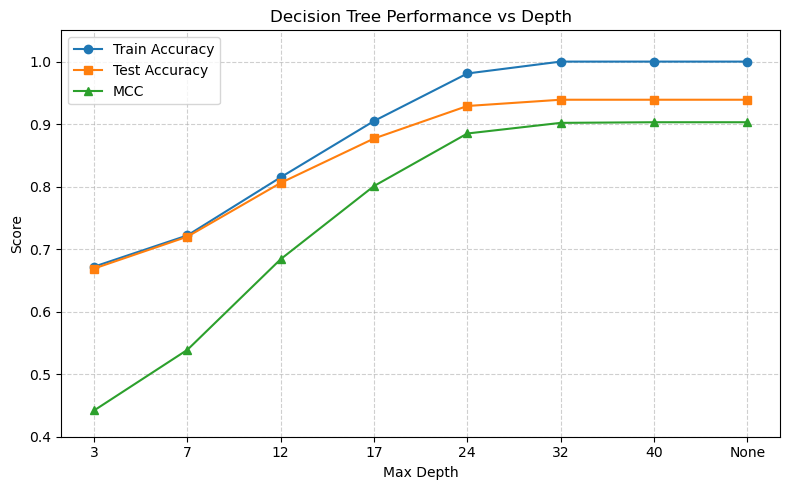

In [106]:
import matplotlib.pyplot as plt

# Data
depths = [3, 7, 12, 17, 24, 32, 40, None]
depths_str = [str(d) if d is not None else "None" for d in depths]

train_acc = [0.672, 0.722, 0.815, 0.905, 0.981, 1.000, 1.000, 1.000]
test_acc  = [0.669, 0.720, 0.806, 0.877, 0.929, 0.939, 0.939, 0.939]
mcc       = [0.442, 0.539, 0.684, 0.801, 0.885, 0.902, 0.903, 0.903]

# Plot
plt.figure(figsize=(8,5))
plt.plot(depths_str, train_acc, marker='o', label="Train Accuracy")
plt.plot(depths_str, test_acc, marker='s', label="Test Accuracy")
plt.plot(depths_str, mcc, marker='^', label="MCC")

# Labels & legend
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Decision Tree Performance vs Depth")
plt.ylim(0.4, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()
